# Summarise the previous results: clean and add the volume and dual computation functions, validate the results


Test case based on the experiment by Lunowa et al. (2022) _Dynamic Effects during the Capillary Rise of Fluids in Cylindrical Tubes_. 

In [1]:

from scipy.spatial import Delaunay
#import polyscope as ps

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports and physical parameters
# std library

# plotting

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._misc import *
from ddgclib._plotting import *

# compute duals (and Delaunay dual from a set of points)
from ddgclib.ddgclib.barycentric import compute_vd, triang_dual

# Plots
from ddgclib.ddgclib.barycentric import plot_dual_mesh_2D, plot_dual_mesh_3D

# Geometry and dual computations
from ddgclib.ddgclib.barycentric import plot_dual, v_star
              
# Boundary geometry                  
from ddgclib.ddgclib.barycentric import  _set_boundary


# Area computations

# Volume computations (including helper functions)


# DDG gradient operations on primary edges (for continuum)

def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points




# 2D

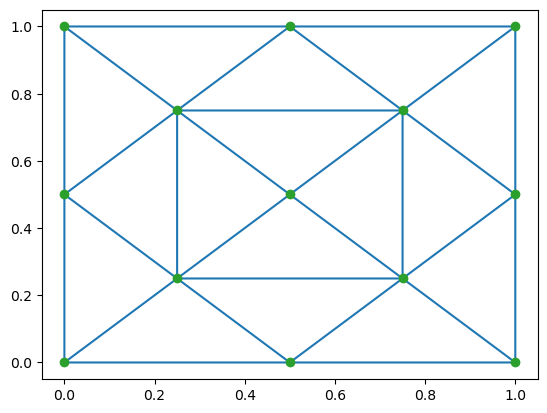

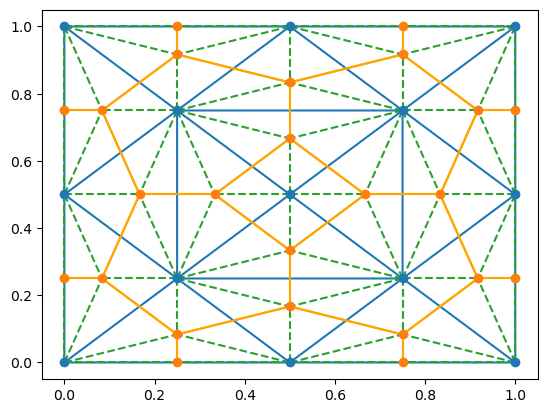

In [2]:
#NOTE: This was moved after defining the code below to validate the 2D:
domain = [(0, 1),]*2

points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
# NEW: Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0) or
        (v.x_a[0] == 1.0 or v.x_a[1] == 1.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv)
    
# Now compute duals as normal   
compute_vd(HC, cdist =1e-10)

plot_dual_mesh_2D(HC, tri, points)

# 3 D


From the paper we expect to reach equilibrium after ∼0.05 s when using the parameters defined in the next cell:

In [3]:
r_list = np.array([0.375, 0.5, 0.65]) *1e-3  # m, Tube radii for 3 experiments
r = 0.5e-3  # m, Default ube radius

gamma = 0.0728  # N/m, surface tension of water at 20 deg C
mu = 0.001  # Pa s, viscosity
rho = 997  # kg/m3, density

g = 9.81  # m/s2
# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
theta_p = 9.99* np.pi/180.0  # Three phase contact angle (degrees immediately converted to radius

# Initial contition
theta_i = 0#2*np.pi  #TODO: Doesn't really do anything yet unless equilibrium is set to True

# Jurin equilibrium height in m:
h_jurin = 2 * gamma * np.cos(theta_p) / (rho * g * r)
h_jurin 



0.029321894204747585

NOTE: From the paper we expect a rise time is roughly 0.3 s

The initial condition is atmospheric pressure at the bottom of the tube (assume the tube is "instantly" inserted and appears below the water line)

The rest of the pressure initial condition should follow rho g h increase.

Different boundary conditions will be explored.

In [4]:
def _cap_rise_meniscus_init(r, theta_i, gamma, N=4, refinement=0,
                            cdist=1e-10, equilibrium=True):
    """
    Helper function to generate the initial film
    :param r: 
    :param theta_i: 
    :param gamma: 
    :param N: 
    :param refinement: 
    :return: 
    """
    Theta = np.linspace(0.0, 2 * np.pi, N)  # range of theta
    R = r / np.cos(theta_i)  # = R at theta = 0
    # Exact values:
    K_f = (1 / R) ** 2
    H_f = 1 / R + 1 / R  # 2 / R
    dp_exact = gamma * (2 / R)  # Pa      # Young-Laplace equation  dp = - gamma * H_f = - gamma * (1/R1 + 1/R2)
    F = []
    nn = []
    F.append(np.array([0.0, 0.0, R * np.sin(theta_i) - R]))
    nn.append([])
    ind = 0
    for theta in Theta:
        ind += 1
        # Define coordinates:
        # x, y, z = sphere(R, theta, phi)
        F.append(np.array([r * np.sin(theta), r * np.cos(theta), 0.0]))
        # Define connections:
        nn.append([])
        if ind > 0:
            nn[0].append(ind)
            nn[ind].append(0)
            nn[ind].append(ind - 1)
            nn[ind].append((ind + 1) % N)

    # clean F
    for f in F:
        for i, fx in enumerate(f):
            if abs(fx) < 1e-15:
                f[i] = 0.0

    F = np.array(F)
    nn[1][1] = ind

    # Construct complex from the initial geometry:
    HC = construct_HC(F, nn)
    v0 = HC.V[tuple(F[0])]
    # Compute boundary vertices
    V = set()
    for v in HC.V:
        V.add(v)
    bV = V - set([v0])
    for i in range(refinement):
        V = set()
        for v in HC.V:
            V.add(v)
        HC.refine_all_star(exclude=bV)
        # New boundary vertices:
        for v in HC.V:
            if v.x[2] == 0.0:
                bV.add(v)

    # Move to spherical cap
    for v in HC.V:
        z = v.x_a[2]
        z_sphere = z - R * np.sin(theta_i)  # move to origin
        # z_sphere = R * np.cos(phi)  # For a sphere centered at origin
        phi_v = np.arccos(z_sphere/R)
        plane_dist = R * np.sin(phi_v)
        # Push vertices on the z-slice the required distance
        z_axis = np.array([0.0, 0.0, z])  # axial centre
        vec = v.x_a - z_axis
        s = np.abs(np.linalg.norm(vec) - plane_dist)
        nvec = normalized(vec)[0]
        nvec = v.x_a + s * nvec
        HC.V.move(v, tuple(nvec))
        vec = nvec - z_axis
        np.linalg.norm(vec)

    # Rebuild set after moved vertices (appears to be needed)
    bV = set()
    for v in HC.V:
        if v.x[2] == 0.0:
            bV.add(v)

    if not equilibrium:
        # Move to zero, for mean flow simulations
        VA = []
        for v in HC.V:
            if v in bV:
                continue
            else:
                VA.append(v.x_a)

        VA = np.array(VA)
        for i, v_a in enumerate(VA):
            v = HC.V[tuple(v_a)]
            v_new = tuple(v.x_a - np.array([0.0, 0.0, v.x_a[2]]))
            HC.V.move(v, v_new)


    return F, nn, HC, bV, K_f, H_f

def cap_rise_init_dyn(r, theta_i, gamma, N=4, refinement=0, depth_dist=0.06, depth_ref=3, cdist=1e-10,
                    equilibrium=True):
    """
    
    :param r: 
    :param theta_i: Initial angle
    :param gamma: 
    :param N: 
    :param refinement: 
    :param cdist: 
    :param equilibrium: 
    :return: 
    """
    F, nn, HC, bV, K_f, H_f = _cap_rise_meniscus_init(r, theta_i, gamma, N, refinement, cdist=1e-10, equilibrium=False)
    
    # Save the points and boundary points
    V_points = []
    bV_points = []
    for v in HC.V:
        V_points.append(v.x_a)
    
    for bv in bV:
        print(f'bv.x_a = {bv.x_a}')
        bV_points.append(bv.x_a)
    
    V_points_film = np.array(V_points)
    bV_points_film = np.array(bV_points)
    print(f'V_points_film.shape = {V_points_film.shape}')
    print(f'bV_points_film.shape = {bV_points_film.shape}')
    # Extend the meniscus film down to a tube below the water line:
    dx = depth_dist/depth_ref
    h = 0  # Height layer tracker
    for i in range(depth_ref):
        # Add new points
        for v in V_points_film:
            v_new = copy.copy(v)
            v_new[2] = v_new[2] + h
            V_points.append(v_new)
            
        # Track new boundary points 
        for bv in bV_points_film:
            bv_new = copy.copy(bv)
            bv_new[2] = bv_new[2] + h
            bV_points.append(bv_new)
            
        h -= dx  # Update next layer height
        
    V_points = np.array(V_points)
    bV_points_a = np.array(bV_points)
    
    # Reconstruct the complex using these values:
    HC = Complex(3)
    for va in V_points:
        v = HC.V[tuple(va)]
        # Set default boundary off
        v.boundary = False

    
    tri = Delaunay(V_points)
    for t in tri.simplices:
        for v1i in t:
            v1a = V_points[v1i]
            v1 = HC.V[tuple(v1a)]
            for v2i in t:
                v2a =  V_points[v2i]
                v2 = HC.V[tuple(v2a)]
                v1.connect(v2)
    
    # Add boundary conditions:
    for vba in bV_points_a:
        vb = HC.V[tuple(vba)]
        vb.boundary = True
        
    # All the top and bottom points must also be boundary points (in the future use boundary function):
    h += dx  # Reset height to last layer in loop
    for v in V_points_film:
        v_new = copy.copy(v)
        v1 = HC.V[tuple(v_new)]
        v1.boundary = True
        v_new[2] = v_new[2] + h
        v2 = HC.V[tuple(v_new)]
        v2.boundary = True
        bV_points.append(v1.x_a)
        bV_points.append(v2.x_a)
    
    bV_points = np.array(bV_points)
    print(f'V_points.shape = {V_points.shape}')
    print(f'bV_points.shape = {bV_points.shape}')
    
    # Clean up:
    HC.V.merge_all(cdist)
    
    bV = set()
    for vba in bV_points:
        vb = HC.V[tuple(vba)]
        bV.add(vb)
    print(f'bV = {bV}')
    return HC, bV

In [5]:
tri = Delaunay([[0, 1], [1, 2], [0, 0]])
tri.points

array([[0., 1.],
       [1., 2.],
       [0., 0.]])

bv.x_a = [0.     0.0005 0.    ]
bv.x_a = [-0.00043301 -0.00025     0.        ]
bv.x_a = [ 0.00043301 -0.00025     0.        ]
V_points_film.shape = (4, 3)
bV_points_film.shape = (3, 3)
V_points.shape = (12, 3)
bV_points.shape = (17, 3)
bV = {<ddgclib._vertex.VertexCube object at 0x77c5c6287bd0>, <ddgclib._vertex.VertexCube object at 0x77c5c6286290>, <ddgclib._vertex.VertexCube object at 0x77c5c62853d0>, <ddgclib._vertex.VertexCube object at 0x77c5c6285ed0>, <ddgclib._vertex.VertexCube object at 0x77c5c62875d0>, <ddgclib._vertex.VertexCube object at 0x77c5c62868d0>, <ddgclib._vertex.VertexCube object at 0x77c5c6285290>, <ddgclib._vertex.VertexCube object at 0x77c5c62862d0>}


/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


(<Figure size 640x480 with 1 Axes>, <Axes3D: >, None, None)

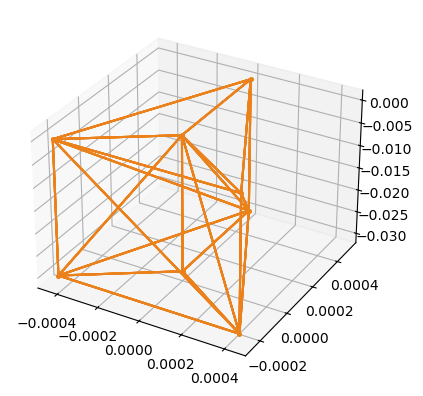

In [6]:
#F, nn, HC, bV, K_f, H_f = cap_rise_init_dyn(r, theta_i, gamma, N=4, refinement=0, depth_dist=0.06, depth_ref=3, cdist=1e-8, equilibrium=False)
HC, bV = cap_rise_init_dyn(r, theta_i, gamma, N=4, refinement=0, depth_dist=0.06, depth_ref=2, cdist=1e-7, equilibrium=False)
HC.plot_complex()

In [7]:
print(f'pre merge HC.V.size() = {HC.V.size()}')
HC.V.merge_all(cdist=1e-9)
print(f'after merge HC.V.size() = {HC.V.size()}')

pre merge HC.V.size() = 8
after merge HC.V.size() = 8


In [8]:
for v in HC.V:
    print(len(v.nn))

4
5
6
7
7
6
5
4


In [9]:
bV = HC.boundary()
bV

set()

In [10]:
#bV = HC.boundary()
def boundary_3D(HC):
    dV = set()
    d = HC.dim
    # expected boundary incidence, = 3 for d=3, and = 1 for d=2:
    boundary_incidence = ((d + 1) * 2 - d - 2)  
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find the intersection of nn sets:
            v1nn_v2nn = v1.nn.intersection(v2.nn)
            if d == 2:
                if len(v1nn_v2nn) < d:
                    dV.add(v1)
                    dV.add(v2)
                else:
                    continue

            if len(v1nn_v2nn) == boundary_incidence:
                dV.add(v1)
                dV.add(v2)
            else:
                continue
    return dV

bV = boundary_3D(HC)

for v in HC.V:
    v.boundary = False
    
for v in bV:
    v.boundary = True
    
for v in HC.V:
    print(f'v.x_a = {v.x}: b.boundary = {v.boundary}')

v.x_a = (0.0, 0.0005000000000000000104, 0.0): b.boundary = True
v.x_a = (0.00043301270189221938318, -0.00024999999999999991725, 0.0): b.boundary = True
v.x_a = (-0.00043301270189221920165, -0.0002500000000000002316, 0.0): b.boundary = True
v.x_a = (0.0, 0.0, 0.0): b.boundary = True
v.x_a = (0.0, 0.0005000000000000000104, -0.02999999999999999889): b.boundary = True
v.x_a = (0.00043301270189221938318, -0.00024999999999999991725, -0.02999999999999999889): b.boundary = True
v.x_a = (-0.00043301270189221920165, -0.0002500000000000002316, -0.02999999999999999889): b.boundary = True
v.x_a = (0.0, 0.0, -0.02999999999999999889): b.boundary = True


In [11]:
bV

{<ddgclib._vertex.VertexCube at 0x77c5c6285290>,
 <ddgclib._vertex.VertexCube at 0x77c5c6287bd0>}

In [12]:
compute_vd(HC, cdist =1e-12)

In [13]:
for vi in HC.V:
    for vj in vi.nn:
        n = vj.x_a - vi.x_a 
        v_star(vi, vj, HC, n=None, dim=3)

/home/endres/projects/ddg/ddgclib/barycentric/_duals.py:1858: RuntimeWarning: invalid value encountered in scalar divide
  projected_extra_point = extra_point - np.dot(extra_point - points[0], normal_vector) / np.linalg.norm(normal_vector)**2 * normal_vector


KeyError: <barycentric._vertex.VertexScalarField object at 0x77c5bc1f5290>

In [ ]:
#%matplotlib notebook
# Compute duals     
#compute_vd(HC, cdist =1e-12)

# Add dual points
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)
plt.show()

In [14]:
vi = HC.V[(0.0, 0.0, -0.020000000000000000416)]
vi = HC.V[(0.0, 0.0, 0.0)]

for vd in vi.vd:
    print(f'vd = {vd.x}')

vd = (-0.0001443375672974064, -8.333333333333341e-05, -0.02)
vd = (0.0002165063509461097, 5.421010862427522e-20, -0.015)
vd = (5.421010862427522e-20, -2.710505431213761e-20, -0.015)
vd = (-0.00010825317547305474, -0.00018750000000000009, -0.015)
vd = (0.00028867513459481295, -0.0001666666666666666, -0.01)
vd = (-0.0001082531754730548, 0.00018749999999999995, -0.0075)
vd = (0.00014433756729740648, 8.333333333333337e-05, 0.0)
vd = (-0.0001082531754730548, 6.249999999999995e-05, -0.0225)
vd = (7.228014483236696e-20, -0.00016666666666666672, 0.0)
vd = (0.00014433756729740648, -8.33333333333333e-05, -0.02)
vd = (-0.0001443375672974064, 8.333333333333326e-05, 0.0)
vd = (0.00014433756729740648, 8.333333333333337e-05, -0.02)
vd = (7.228014483236696e-20, -0.00016666666666666672, -0.02)
vd = (-0.0001443375672974064, 8.333333333333326e-05, -0.02)
vd = (0.0, 0.0003333333333333333, -0.01)
vd = (0.0, 0.0002500000000000000052, 0.0)
vd = (5.421010862427522e-20, -0.00012500000000000003, -0.0225)
vd = (

In [ ]:
plot_dual(vi, HC)
ps.show()

In [ ]:
N=4
#N=7
#N=15
refinement=0
depth_dist=0.06
depth_ref=3
cdist=1e-10

In [ ]:
F, nn, HC, bV, K_f, H_f = _cap_rise_meniscus_init(r, theta_i, gamma, N, refinement, cdist=1e-10, equilibrium=False)

# Save the points and boundary points
V_points = []
bV_points = []
for v in HC.V:
    V_points.append(v.x_a)

for bv in bV:
    print(f'bv.x_a = {bv.x_a}')
    bV_points.append(bv.x_a)

V_points_film = np.array(V_points)
bV_points_film = np.array(bV_points)
print(f'V_points_film.shape = {V_points_film.shape}')
print(f'bV_points_film.shape = {bV_points_film.shape}')
# Extend the meniscus film down to a tube below the water line:
dx = depth_dist/depth_ref
h = 0  # Height layer tracker
for i in range(depth_ref):
    # Add new points
    for v in V_points_film:
        v_new = copy.copy(v)
        v_new[2] = v_new[2] + h
        V_points.append(v_new)
        
    # Track new boundary points 
    for bv in bV_points_film:
        bv_new = copy.copy(bv)
        bv_new[2] = bv_new[2] + h
        bV_points.append(bv_new)
        
    h -= dx  # Update next layer height
    
V_points = np.array(V_points)
bV_points_a = np.array(bV_points)

# Reconstruct the complex using these values:
HC = Complex(3)
for va in V_points:
    v = HC.V[tuple(va)]
    # Set default boundary off
    v.boundary = False


tri = Delaunay(V_points)
for t in tri.simplices:
    for v1i in t:
        v1a = V_points[v1i]
        v1 = HC.V[tuple(v1a)]
        for v2i in t:
            v2a =  V_points[v2i]
            v2 = HC.V[tuple(v2a)]
            v1.connect(v2)

# Add boundary conditions:
for vba in bV_points_a:
    vb = HC.V[tuple(vba)]
    vb.boundary = True
    
# All the top and bottom points must also be boundary points (in the future use boundary function):
h += dx  # Reset height to last layer in loop
for v in V_points_film:
    v_new = copy.copy(v)
    v1 = HC.V[tuple(v_new)]
    v1.boundary = True
    v_new[2] = v_new[2] + h
    v2 = HC.V[tuple(v_new)]
    v2.boundary = True
    bV_points.append(v1.x_a)
    bV_points.append(v2.x_a)


####################################
# Plot
####################################
V_points = np.array(V_points, dtype=np.float64)
bV_points = np.array(bV_points, dtype=np.float64)
if 1:
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    points = V_points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    ax.scatter(bV_points[:, 0], bV_points[:, 1], bV_points[:, 2], color='r')
    plt.show()
    
    
if 1:
    %matplotlib notebook
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.spatial import Delaunay
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    
    # assume your 3D points are in a N x 3 numpy array called `points`
    dpoints = []
    for p in points:
        pn = copy.copy(p)
        #pn = pn + 1e-15 * np.random.rand(3)
        #pn = pn + 1e-5 * np.ones(3)
        dpoints.append(pn)
    
    
    tri = Delaunay(dpoints, qhull_options='Qz')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    
    #for s in tri.simplices:
    #    ax.plot3D(points[s, 0], points[s, 1], points[s, 2], 'b-')
     
    triangles = tri.points[tri.simplices]
    collection = Poly3DCollection(triangles, alpha =0.45)
    face_color = [0.5, 0.5, 1]
    collection.set_facecolor(face_color)
    edge_color = [0, 0, 0]
    collection.set_edgecolor(edge_color)
    ax.add_collection3d(collection)   
    plt.show()

In [ ]:
bV_points

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# assume your 3D points are in a N x 3 numpy array called `points`
dpoints = []
for p in points:
    pn = copy.copy(p)
    pn = pn + 1e-15 * np.random.rand(3)
    #pn = pn + 1e-5 * np.ones(3)
    dpoints.append(pn)


tri = Delaunay(dpoints, qhull_options='Qz')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

#for s in tri.simplices:
#    ax.plot3D(points[s, 0], points[s, 1], points[s, 2], 'b-')
 
triangles = tri.points[tri.simplices]
collection = Poly3DCollection(triangles, alpha =0.45)
face_color = [0.5, 0.5, 1]
collection.set_facecolor(face_color)
edge_color = [0, 0, 0]
collection.set_edgecolor(edge_color)
ax.add_collection3d(collection)   
plt.show()

# Test random points

In [ ]:
#np.random.seed(121658188)
np.random.seed(180)
points = np.random.rand(10, 3)
points
tri = Delaunay(points, qhull_options='Qz')
HC = Complex(3)
for t in tri.simplices:
    for v1ai in t:
        v1a = points[v1ai]
        v1 = HC.V[tuple(v1a)]
        for v2ai in t:
            v2a = points[v2ai]
            v2 = HC.V[tuple(v2a)]
            v1.connect(v2)
            
            
HC.plot_complex()
HC.V.merge_all(cdist =1e-12)
bV = HC.boundary()
bV
for v in HC.V:
    v.boundary = False
for v in bV:
    v.boundary = True


len(list(bV)), compute_vd(HC, cdist =1e-12)

In [ ]:
points, v.x

In [ ]:
plot_dual(v, HC)

# Test new boundary method

In [ ]:


np.random.seed(180)
points = np.random.rand(10, 3)
points
tri = Delaunay(points, qhull_options='Qz')
HC = Complex(3)
for t in tri.simplices:
    for v1ai in t:
        v1a = points[v1ai]
        v1 = HC.V[tuple(v1a)]
        for v2ai in t:
            v2a = points[v2ai]
            v2 = HC.V[tuple(v2a)]
            v1.connect(v2)
            
            
#HC.plot_complex()
HC.V.merge_all(cdist =1e-12)

def boundary_3D(HC):
    dV = set()
    d = HC.dim
    # expected boundary incidence, = 3 for d=3, and = 1 for d=2:
    boundary_incidence = ((d + 1) * 2 - d - 2)  
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find the intersection of nn sets:
            v1nn_v2nn = v1.nn.intersection(v2.nn)
            if d == 2:
                if len(v1nn_v2nn) < d:
                    dV.add(v1)
                    dV.add(v2)
                else:
                    continue

            if len(v1nn_v2nn) == boundary_incidence:
                dV.add(v1)
                dV.add(v2)
            else:
                continue
    return dV


bV_old = HC.boundary()
bV = boundary_3D(HC)
bV
for v in HC.V:
    v.boundary = False
for v in bV:
    v.boundary = True

compute_vd(HC, cdist =1e-12)

len(list(bV_old)), len(list(bV))#, compute_vd(HC, cdist =1e-12)

In [ ]:
d = 3
((d + 1) * 2 - d - 2)

In [ ]:
compute_vd(HC, cdist =1e-12)

In [ ]:
for v in HC.V:
    if v in bV:
        print('boundary')
    else:
        break

In [ ]:
def plot_dual(v, HC, vector_field=None, scalar_field=None, fn='', up="x_up"
              , stl=False):
    v1 = v
    # Initialize polyscope
    ps.init()
    ps.set_up_dir('z_up')
    do = coldict['do']
    lo = coldict['lo']
    db = coldict['db']
    lb = coldict['lb']
    tg = coldict['tg']  # Tab:green colour
    # %% Plot Barycentric dual mesh
    # Loop over primary edges
    dual_points_set = set()
    ssets = []  # Sets of simplices
    v1 = v
    for i, v2 in enumerate(v1.nn):
        # Find the dual vertex of e12:
        vc_12 = 0.5 * (v2.x_a - v1.x_a) + v1.x_a  # TODO: Should be done in the compute_vd function
        vc_12 = HC.Vd[tuple(vc_12)]

        # Find local dual points intersecting vertices terminating edge:
        dset = v2.vd.intersection(v1.vd)  # Always 5 for boundaries
        # Start with the first vertex and then build triangles, loop back to it:
        vd_i = list(dset)[0]
        if v1.boundary and v2.boundary:
            # Remove the boundary edge which should already be in the set:
            if not (len(vd_i.nn.intersection(dset)) == 1):
                for vd in dset:
                    vd_i = vd
                    if len(vd_i.nn.intersection(dset)) == 1:
                        break
            iter_len = 3
        else:
            iter_len = len(list(dset))

            # Main loop
        dsetnn = vd_i.nn.intersection(dset)  # Always 1 internal dual vertices
        vd_j = list(dsetnn)[0]
        # NOTE: In the boundary edges the last triangle does not have
        #      a final vd_j
        print(f'vd_i.nn = {vd_i.nn}')
        print(f'dset = {dset}')
        for _ in range(iter_len):  # For boundaries should be length 2?
            ssets.append([vc_12, vd_i, vd_j])
            dsetnn_k = vd_j.nn.intersection(dset)  # Always 2 internal dual vertices in interior
            print(f'dsetnn_k  = {dsetnn_k }')
            dsetnn_k.remove(vd_i)  # Should now be size 1
            vd_i = vd_j
            try:
                # Alternatively it should produce an IndexError only when
                # _ = 2 (end of range(3) and we are on a boundary edge
                # so that (v1.boundary and v2.boundary) is true
                vd_j = list(dsetnn_k)[0]  # Retrieve the next vertex
            except IndexError:
                pass  # Should only happen for boundary edges

        # Find local dual points intersecting vertices terminating edge:
        dset = v2.vd.intersection(v1.vd)
        pi = []
        for vd in dset:
            # pi.append(vd.x + 1e-9 * np.random.rand())
            pi.append(vd.x)
            dual_points_set.add(vd.x)
        pi = np.array(pi)
        pi_2d = pi[:, :2] + 1e-9 * np.random.rand()

        # Plot dual points:
        dual_points = []
        for vd in dual_points_set:
            dual_points.append(vd)

        dual_points = np.array(dual_points)
        ps_cloud = ps.register_point_cloud("Dual points", dual_points)
        ps_cloud.set_color(do)

    # Build the simplices for plotting
    faces = []
    vdict = collections.OrderedDict()  # Ordered cache of vertices to plot
    ind = 0
    # Now iterate through all the constructed simplices and find indexes
    for s in ssets:
        f = []
        for v in s:
            if not (v.x in vdict):
                vdict[v.x] = ind
                ind += 1

            f.append(vdict[v.x])
        faces.append(f)

    verts = np.array(list(vdict.keys()))
    faces = np.array(faces)

    dsurface = ps.register_surface_mesh(f"Dual face {i}", verts, faces,
                                        color=do,
                                        edge_width=0.0,
                                        edge_color=(0.0, 0.0, 0.0),
                                        smooth_shade=False)

    # Plot primary mesh
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)

    # %% Register the primary vertices as a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("Primary points", my_points)
    ps_cloud.set_color(tuple(db))
    # ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    if stl:
        #  msh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
        for i, f in enumerate(faces):
            for j in range(3):
                pass
                # msh.vectors[i][j] = verts[f[j], :]

        # msh.save(f'{fn}.stl')

    ### Plot the primary mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    if 1:
        surface = ps.register_surface_mesh("Primary surface", verts, faces,
                                           color=db,
                                           edge_width=1.0,
                                           edge_color=(0.0, 0.0, 0.0),
                                           smooth_shade=False)

        surface.set_transparency(0.3)
        # Add a scalar function and a vector function defined on the mesh
        # vertex_scalar is a length V numpy array of values
        # face_vectors is an Fx3 array of vectors per face

        # View the point cloud and mesh we just registered in the 3D UI
        # ps.show()
        # Plot particles
        # Ground plane options
        ps.set_ground_plane_mode("shadow_only")  # set +Z as up direction
        ps.set_ground_plane_height_factor(0.1)  # adjust the plane height
        ps.set_shadow_darkness(0.2)  # lighter shadows
        ps.set_shadow_blur_iters(2)  # lighter shadows
        ps.set_transparency_mode('pretty')
        # ps.look_at((0., -10., 0.), (0., 0., 0.))
        ps.look_at((1., -8., -8.), (0., 0., 0.))
        # ps.set_ground_plane_height_factor(x, is_relative=True)
        ps.set_screenshot_extension(".png")
        # Take a screenshot
        # It will be written to your current directory as screenshot_000000.jpg, etc
        ps.screenshot(fn)
    return ps

plot_dual(v, HC)

In [ ]:
plot_dual(v, HC)

In [ ]:
HC.plot_complex()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# assume your 3D points are in a N x 3 numpy array called `points`
dpoints = []
for p in points:
    pn = copy.copy(p)
    #pn = pn + 1e-15 * np.random.rand(3)
    #pn = pn + 1e-5 * np.ones(3)
    dpoints.append(pn)


tri = Delaunay(dpoints, qhull_options='Qz')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

#for s in tri.simplices:
#    ax.plot3D(points[s, 0], points[s, 1], points[s, 2], 'b-')
 
triangles = tri.points[tri.simplices]
collection = Poly3DCollection(triangles, alpha =0.45)
face_color = [0.5, 0.5, 1]
collection.set_facecolor(face_color)
edge_color = [0, 0, 0]
collection.set_edgecolor(edge_color)
ax.add_collection3d(collection)   
plt.show()

# Old code

In [ ]:
ub = 4.0
domain = [(0, ub),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
for i in range(0):
    HC.refine_all_star()

# NEW
# Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0 or v.x_a[2] == 0.0) or
        (v.x_a[0] == ub or v.x_a[1] == ub or v.x_a[2] == ub)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv, True)
for v in HC.V:
    if not (v in bV):
        _set_boundary(v, False)
    
    
#for v in HC.V:
#    if (v in bV):
#        continue
#    else:
#        _set_boundary(bv, False)
        
# Compute duals     
compute_vd(HC, cdist =1e-10)

# Add dual points
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)
#dual_points

import polyscope as ps
v = HC.V[(0.0, 0.0, 0.0)]
v2 = HC.V[(0.0, ub, ub)]
#TEST fix of dual point:
#vd = [0.0, 1.5, 2.5]


In [ ]:
vj = HC.V[(2.0, 2.0, 2.0)]
vj = HC.V[(ub/2.0, ub/2.0, ub/2.0)]
vi = HC.V[(0.0, 0.0, 0.0)]
#e_star(vi, vj, HC, HC.dim)
v_star(vi, vj, HC, n=None, dim=3)

In [ ]:
V = 0
for vi in HC.V:
    for vj in vi.nn:
        dv = v_star(vi, vj, HC, n=None, dim=3)
        #print(np.sum(dv[0], axis=0))
        print(np.linalg.norm(dv[0]))
        V += np.sum(dv[1] )
        
        
V, ub**3

In [ ]:

plot_dual(vi, HC)
ps.show()


In [ ]:
import polyscope as ps

ps.init()

def callback():
    # Executed every frame
    # Do computation here, define custom UIs, etc.
    print("executing callback")
    plot_dual(vi, HC)

ps.set_user_callback(callback)

ps.show()

ps.clear_user_callback()

In [ ]:
np.random.rand(2, 3)

In [ ]:
import polyscope as ps
import numpy as np
import time

# Initialize the visualization
ps.init()
plot_dual(vi, HC)

# Define a callback function
def callback():
    global HC
    
    # Update primary mesh
    Vc = copy.copy(HC.V)
    for v in Vc:
        vn = v.x_a + 0.1 * np.random.rand(3)
        HC.V.move(v, tuple(vn))
    
    # Update dual mesh
    if 0:
        compute_vd(HC, cdist =1e-10)
        # Add dual points
        dual_points = []
        for vd in HC.Vd:
            dual_points.append(vd.x_a)
    
    #dual_points = np.array(dual_points, dtype='float64')
    #hcaxes.scatter(dual_points)
    #plot_dual_mesh_3D(HC, dual_points)
    plot_dual(vi, HC)
    # Update the point cloud data
    # Print a message to indicate that the callback is working
    print("Callback executed!")
    time.sleep(0.1)

# Set the callback function
ps.set_user_callback(callback)

# Show the visualization
ps.show()

# Clear the callback function
ps.clear_user_callback()



In [ ]:
# Update primary mesh
Vc = copy.copy(HC.V)
for v in Vc:
    vn = v.x_a + 0.1 * np.random.rand(3)
    HC.V.move(v, tuple(vn))

# Update dual mesh
if 1:
    compute_vd(HC, cdist =1e-10)
    # Add dual points
    dual_points = []
    for vd in HC.Vd:
        dual_points.append(vd.x_a)

#dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
#plot_dual_mesh_3D(HC, dual_points)
plot_dual(vi, HC)